## NMF for Speaker Separation

Non-negative matrix factorization from a single microphone, with ideas taken from [Stanford's course](https://ccrma.stanford.edu/~njb/teaching/sstutorial/part2.pdf). Underlying idea is take a spectrogram $V$, and decompose it to construct its atomic bases set $W$ and $H$, so that:

$$ V = W H $$

This is just a baseline, without real confidence in its applicability. The trouble with NMF speaker separation on human voices is that the spectrogram for speech is dynamic over the course of an entire spectrogram. Not only will our voice modulate, individual syllables may cover large swaths of frequency.

![Monaural NMF](images/nmf-monaural.png)


In [1]:
# Scientific libraries
import scipy
import pylab
import numpy as np
import numpy.ma as ma
from nmf import nmf

# Audio libraries
from scipy.io import wavfile
from IPython.display import display, Audio

# Operational libraries
import os
import sys
import matplotlib.pylab as plt
%matplotlib inline

# Magnolia libraries
sys.path.append('../')
from utils.norm_wav import norm_wav
from features.spectral_features import *

## Read in the data

In [2]:
# Read in the data
audio_dir = "/Users/kni/Code/Magnolia/data/sisec-dev"
fs, snda = wavfile.read(os.path.join(audio_dir, "dev_Ca1_Ce_A_src.wav"))
fs, sndb = wavfile.read(os.path.join(audio_dir, "dev_Ca1_Ce_B_src.wav"))
sndab = snda+sndb

# Normalize the data
snda = norm_wav( snda )
sndb = norm_wav( sndb )
sndab = norm_wav( sndab )

## Spectral transform and component decomposition

The decomposition below fits a model:

$$ \| X - WH \|_F^2 + \alpha \lambda_1 \| W \|_1 + \alpha \lambda_1 \| H \|_1  $$

Unfortunately, the code below only stores $W$, and leaves the user to calculate $H$ (see below)

In [3]:
sndabft = stft( sndab, fs, 0.05, 0.025)
W,H = nmf(abs(sndabft), 8)

## Reconstruction (first Fourier and time-domain)

Based on the spectral decomposition in the above cell, where

### Reconstruction thresholded mask

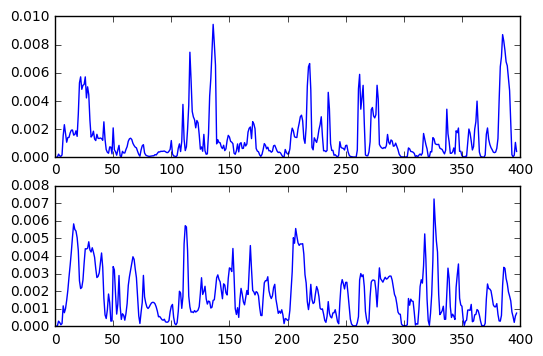

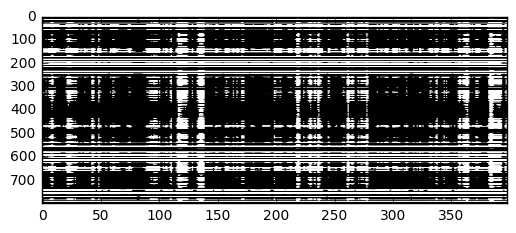

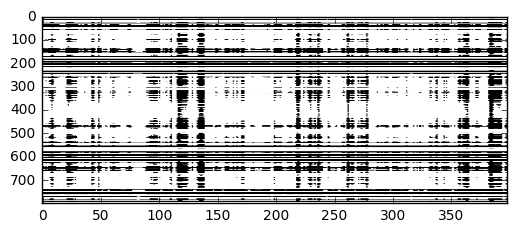

In [4]:
ws = H
masks = np.zeros((len(H),) + sndabft.shape)
for i,wi in enumerate(H):
    ws[i]= wi / np.linalg.norm(wi)
    energyi = ws[i].dot(abs(sndabft).T)
    masks[i] = np.outer( energyi, ws[i] )
    
maska = (masks[0]) > (masks[1])
maskb = (masks[1]) > (masks[0])

sndareconft = maska*abs(sndabft)*np.exp( 1j* np.angle(sndabft))  # Apply mask A
sndarecon = istft( sndareconft, fs, 5, 0.025 )

sndbreconft = maskb*abs(sndabft)*np.exp( 1j* np.angle(sndabft))  # Apply mask B = 1 - A
sndbrecon = istft( sndbreconft, fs, 5, 0.025 )

plt.figure();
plt.subplot(211); plt.plot( ws[0].dot(abs(sndabft).T)/1e5 )
plt.subplot(212); plt.plot( ws[1].dot(abs(sndabft).T)/1e5 )
plt.figure(); plt.imshow(maska.T, aspect=.2, cmap='bone')
plt.figure(); plt.imshow(maskb.T, aspect=.2, cmap='bone')

### Reconstruction with source filtering

![nmf source filtering](images/nmf-sourcefilter.png)

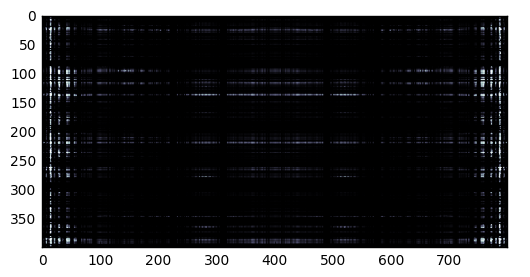

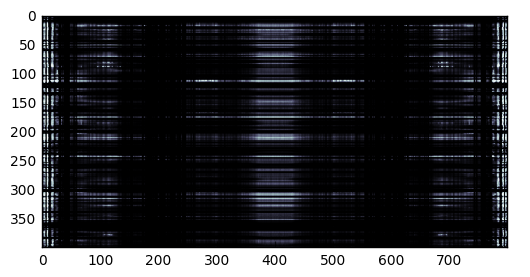

In [5]:
alpha = 1
comps = np.zeros((len(H),len(W), len(H.T)))
for i in range(len(H)):
    comps[i] = ( W[:,i:i+1] @ H[i:i+1,:] )**alpha

aggcomp = comps.sum(axis=0)
masks = comps / aggcomp

sndareconft = masks[0]*abs(sndabft)*np.exp( 1j* np.angle(sndabft))  # Apply mask A
sndarecon = istft( sndareconft, fs, 5, 0.025 )

sndbreconft = masks[1]*abs(sndabft)*np.exp( 1j* np.angle(sndabft))  # Apply mask B = 1 - A
sndbrecon = istft( sndbreconft, fs, 5, 0.025 )

plt.figure(); plt.imshow(masks[0], cmap='bone')
plt.figure(); plt.imshow(masks[1], cmap='bone')

## Play audio

In [6]:
print('Original signal')
display(Audio(sndab, rate=fs))
print('Reconstruction of signal A')
display(Audio(sndarecon,rate=fs))
print('Reconstruction of signal B')
display(Audio(sndbrecon,rate=fs))

Original signal


Reconstruction of signal A


Reconstruction of signal B
